In [1]:
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA



In [2]:
# normalizing data
def normalize_data(da, clip=False):
    # remove outliers
    if clip:
        da = da.clip(
            min=da.attrs["valid_min"],
            max=da.attrs["valid_max"],
        )
    mat   = da.values
    flag  = mat == mat
    mean_ = np.nanmean(mat[flag])
    std_  = np.nanstd(mat[flag])
    print(mean_, std_)
    norm_ = (da - mean_) / std_
    return norm_

In [3]:
poc_mon_mean = xr.open_dataset("POC_monthly_mean.nc")
chl_mon_mean = xr.open_dataset("CHL_monthly_mean.nc")
cphyto_mon_mean = xr.open_dataset("cphyto_monthly_mean.nc")
moana_mon_mean  = xr.open_dataset("moana_monthly_mean_new.nc")
sst = xr.open_dataset("mur_sst_monthly_mean_01.nc")
moana_reindex = moana_mon_mean.reindex_like(cphyto_mon_mean, method="nearest")
sst_reindex = sst.reindex_like(cphyto_mon_mean, method="nearest")
ds_merge = xr.merge([poc_mon_mean, chl_mon_mean, cphyto_mon_mean, moana_reindex, sst_reindex], compat='override').drop_vars("palette")
ds_merge

<xarray.Dataset> Size: 311MB
Dimensions:          (month: 12, lat: 900, lon: 900)
Coordinates:
  * lat              (lat) float32 4kB 59.95 59.85 59.75 ... -29.85 -29.95
  * lon              (lon) float32 4kB -74.95 -74.85 -74.75 ... 14.85 14.95
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    poc              (month, lat, lon) float32 39MB ...
    chlor_a          (month, lat, lon) float32 39MB ...
    carbon_phyto     (month, lat, lon) float32 39MB ...
    prococcus_moana  (month, lat, lon) float32 39MB ...
    syncoccus_moana  (month, lat, lon) float32 39MB ...
    picoeuk_moana    (month, lat, lon) float32 39MB ...
    analysed_sst     (month, lat, lon) float64 78MB ...

### Convert cell count to carbon concentration

In [ ]:
# # pro
# e_pro = 214
# D_pro = .68
# # syn
# e_syn = 203.
# D_syn = 1.22
# # pico
# e_pico = 220.
# D_pico = 

### mask out high chlor_a region

In [4]:
# set chlor_a threshold
chlor_a = 1.5

Text(0.5, 1.0, 'yellow regions are where chlor_a concentration > 1.5 mg/m3')

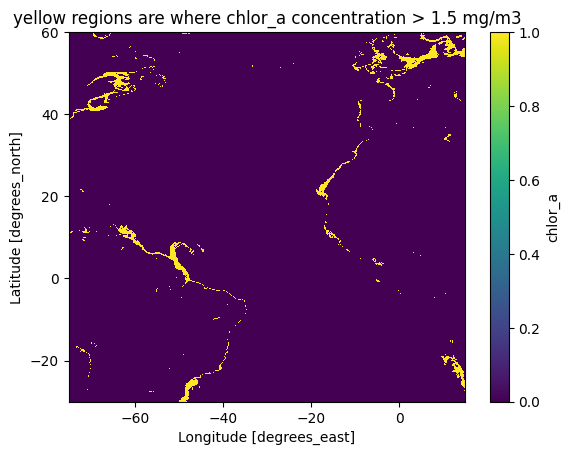

In [5]:
da.plot.imshow(vmin=-30, vmax=30)
plt.title(f"yellow regions are where chlor_a concentration > {chlor_a} mg/m3")

In [6]:
ds_ocean = ds_merge.copy(deep=True)
ds_coast = ds_merge.copy(deep=True)
ds_ocean = ds_ocean.where(ds_ocean.chlor_a < chlor_a)
ds_coast = ds_coast.where(ds_coast.chlor_a > chlor_a)

In [7]:
# normalize ds_coast
ds_coast["poc_norm"] = normalize_data(ds_coast.poc)
ds_coast["chl_norm"] = normalize_data(ds_coast.chlor_a)
ds_coast["cphyto_norm"] = normalize_data(ds_coast.carbon_phyto)
ds_coast["pro"] = normalize_data(ds_coast.prococcus_moana, clip=True)
ds_coast["syn"] = normalize_data(ds_coast.syncoccus_moana, clip=True)
ds_coast["pico"] = normalize_data(ds_coast.picoeuk_moana, clip=True)
ds_coast["sst_norm"] = normalize_data(ds_coast.analysed_sst)

425.0375 220.2603
5.029255 6.271794
136.01436 196.1254
23834.99 82318.805
3643.5308 12227.317
19959.988 11225.351
15.569516018293138 8.768902266217967


In [8]:
ds_ocean["poc_norm"] = normalize_data(ds_ocean.poc)
ds_ocean["chl_norm"] = normalize_data(ds_ocean.chlor_a)
ds_ocean["cphyto_norm"] = normalize_data(ds_ocean.carbon_phyto)
ds_ocean["pro"] = normalize_data(ds_ocean.prococcus_moana, clip=True)
ds_ocean["syn"] = normalize_data(ds_ocean.syncoccus_moana, clip=True)
ds_ocean["pico"] = normalize_data(ds_ocean.picoeuk_moana, clip=True)
ds_ocean["sst_norm"] = normalize_data(ds_ocean.analysed_sst)

58.408947 39.321236
0.21243963 0.2305707
19.640064 10.742159
232316.22 116981.91
12222.058 20675.17
4426.1147 6132.629
22.368322933790086 6.286420676936077


### PCA => loading of pixels

In [9]:
vars_ = ["poc_norm", "chl_norm", "cphyto_norm", "pro", "syn", "pico", "sst_norm"]

In [10]:
mat   = ds_ocean[vars_].to_array()
mask  = ( mat.notnull().sum(dim="variable") == 7 ).values
mat_pca = mat.values[:, mask]


In [16]:
mat_pca.shape

(7, 5502751)

In [11]:
# put it into svd
U, S, Vh = np.linalg.svd(mat_pca, full_matrices=False)
U.shape, S.shape, Vh.shape
# normalize S
S_norm = S / np.sum(S)

In [12]:
loading1 = Vh[0,:]  # projection on the first SV
loading2 = Vh[1,:] # projection on the second SV


In [13]:
ocean_loading1 = np.zeros(mat.shape[1:]) * np.nan
ocean_loading1[mask] = loading1

ocean_loading2 = np.zeros(mat.shape[1:]) * np.nan
ocean_loading2[mask] = loading2


Text(0.5, 0.98, 'July')

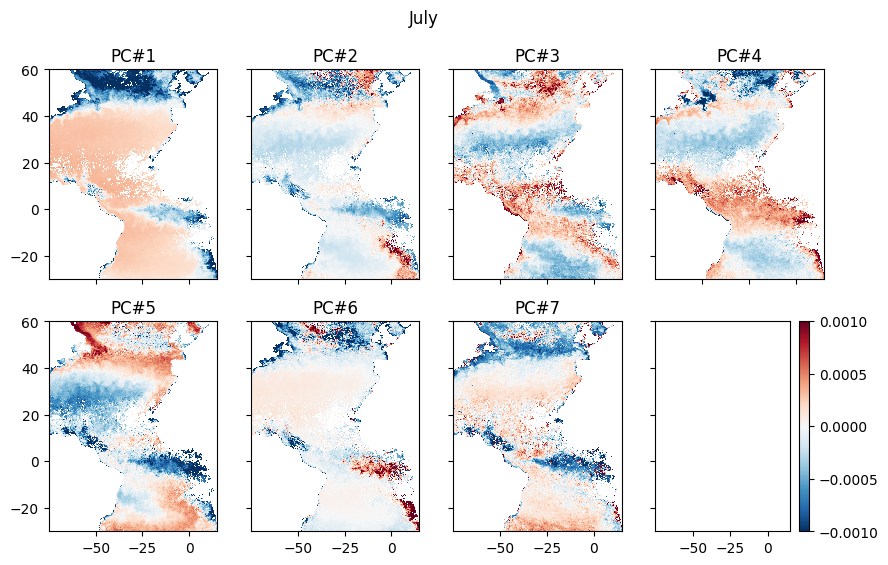

In [14]:
# visualize
lon = ds_ocean.lon
lat = ds_ocean.lat

fig, axes = plt.subplots(2, 4, figsize=(10,6), sharex=True, sharey=True)
ax = axes.flatten()
for i in range(7):
    temp_mat = np.zeros(mat.shape[1:]) * np.nan
    temp_mat[mask] = Vh[i,:]
    cbar = ax[i].pcolormesh(lon, lat, temp_mat[6], vmin=-.001, vmax=.001, cmap="RdBu_r")
    ax[i].set_title(f"PC#{i+1}")

plt.colorbar(cbar, ax=ax[-1])
fig.suptitle("July")

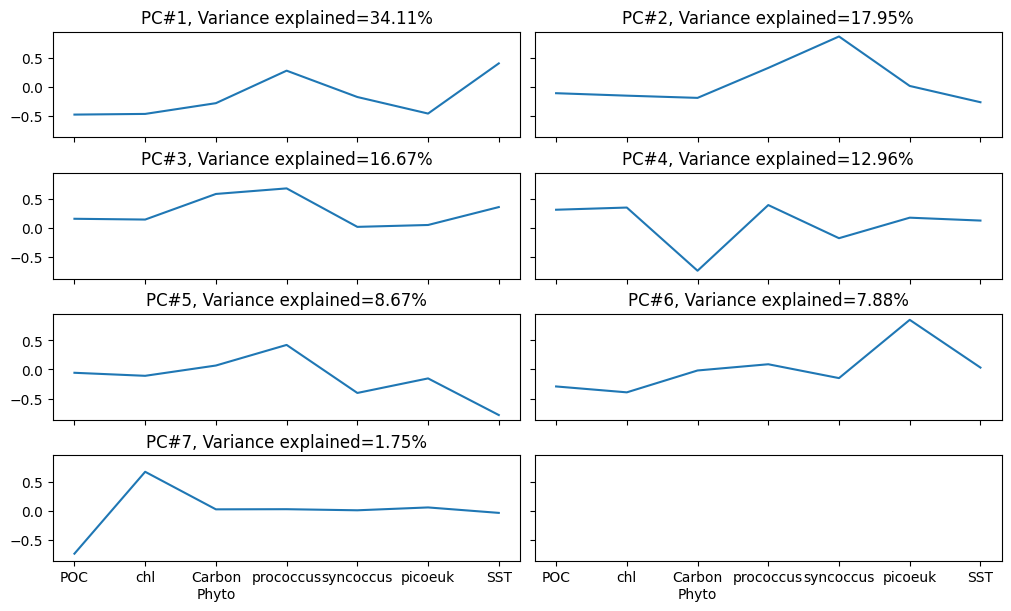

In [23]:
# SVs
varnames = ["POC", "chl", "Carbon\nPhyto", "prococcus", "syncoccus", "picoeuk", "SST"]
fig, axes = plt.subplots(4, 2, figsize=(10,6), sharex=True, sharey=True, layout="constrained")
ax = axes.flatten()
for i in range(7):
    ax[i].plot(U[:,i])
    ax[i].set_title(f"PC#{i+1}, Variance explained={S_norm[i]*100:.2f}%")
    ax[i].set_xticks(ticks=np.arange(len(vars_)), labels=varnames)  

### PCA for coastal regions

In [17]:
vars_ = ["poc_norm", "chl_norm", "cphyto_norm", "pro", "syn", "pico", "sst_norm"]
month_idx = 6 # try July first
mat   = ds_coast[vars_].isel(month=month_idx).to_array() # .reshape(len(vars_), -1)
# remove nan
mask = ( mat.notnull().sum(dim="variable") == 7 ).values

# remove nan and outliers?
# mat[(np.abs(mat)>3)] = np.nan
# mask = (np.nansum(mat==mat, axis=0)==7)

# select
mat_pca = mat.values[:, mask]


In [21]:
matrix_T.shape

(12830, 7)

In [19]:
pca = PCA(n_components=len(vars_))


In [22]:
# because it expects samples (observations) to be rows and features (variables) to be columns.
matrix_T = mat_pca.T
pca.fit(matrix_T)

PCA(n_components=7)

In [23]:
components = pca.components_
components.shape

(7, 7)

In [24]:
cov = pca.get_covariance()
cov.shape

(7, 7)

In [25]:
pca.explained_variance_ratio_

array([0.40993608, 0.19678828, 0.17359715, 0.08778896, 0.07759409,
       0.02991256, 0.02438288])

In [26]:
vars_

['poc_norm', 'chl_norm', 'cphyto_norm', 'pro', 'syn', 'pico', 'sst_norm']

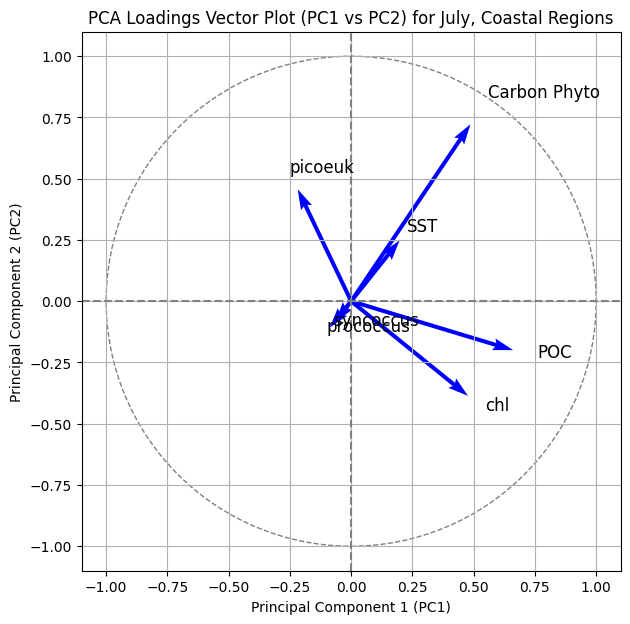

In [27]:
# Assuming the names for the 6 original variables.
variable_names = ["POC", "chl", "Carbon Phyto", "prococcus", "syncoccus", "picoeuk", "SST"]

# Create the vector plot
plt.figure(figsize=(7, 7))

# Plot the vectors for the first two principal components (PC1 vs PC2)
plt.quiver(
    np.zeros(len(variable_names)),
    np.zeros(len(variable_names)),
    components[0, :],  # x-coordinates from PC1 loadings
    components[1, :],  # y-coordinates from PC2 loadings
    angles='xy',
    scale_units='xy',
    scale=1,
    color='b'
)

# Add labels for each vector. We place them slightly outside the tip of the arrow.
for i, name in enumerate(variable_names):
    plt.text(components[0, i] * 1.15, components[1, i] * 1.15, name, color='k', fontsize=12)

# Draw a unit circle to help visualize the magnitude of the loadings
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Set the axis labels and title
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Loadings Vector Plot (PC1 vs PC2) for July, Coastal Regions')
plt.grid()
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')

### PCA for open ocean (July only)

In [27]:
vars_ = ["poc_norm", "chl_norm", "cphyto_norm", "pro", "syn", "pico", "sst_norm"]
month_idx = 6 # try July first
mat   = ds_ocean[vars_].isel(month=month_idx).to_array() # .reshape(len(vars_), -1)
# remove nan
mask = ( mat.notnull().sum(dim="variable") == 7 ).values

# select
mat_pca = mat.values[:, mask]

# because it expects samples (observations) to be rows and features (variables) to be columns.
matrix_T = mat_pca.T
pca.fit(matrix_T)

components = pca.components_
components.shape

(7, 7)

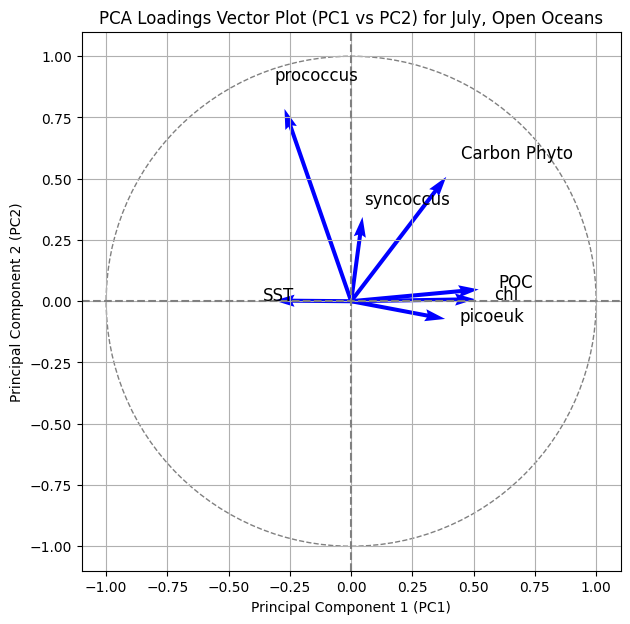

In [28]:
# Assuming the names for the 6 original variables.
variable_names = ["POC", "chl", "Carbon Phyto", "prococcus", "syncoccus", "picoeuk", "SST"]

# Create the vector plot
plt.figure(figsize=(7, 7))

# Plot the vectors for the first two principal components (PC1 vs PC2)
plt.quiver(
    np.zeros(len(variable_names)),
    np.zeros(len(variable_names)),
    components[0, :],  # x-coordinates from PC1 loadings
    components[1, :],  # y-coordinates from PC2 loadings
    angles='xy',
    scale_units='xy',
    scale=1,
    color='b'
)

# Add labels for each vector. We place them slightly outside the tip of the arrow.
for i, name in enumerate(variable_names):
    plt.text(components[0, i] * 1.15, components[1, i] * 1.15, name, color='k', fontsize=12)

# Draw a unit circle to help visualize the magnitude of the loadings
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Set the axis labels and title
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Loadings Vector Plot (PC1 vs PC2) for July, Open Oceans')
plt.grid()
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')